In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# own Modules 
from models import LstmMse, LstmMseDropout
from data_loader import DataPreperator, DataSet
from trainer import Trainer
from loss_module import LossModuleMse, LossModuleMle

## Hyperparameters

In [8]:
hyperparam = {
    "data" : {
        "stake_training_data" : 0.75, 
        "path" : '../../../data/artifical_signals/' 
    },
    "model" : {
        "input_size" : 8,
        "n_hidden" : 150,
        "sequence_size" : 20,
        "batch_size" : 8,
        "lstm_layer" : 3,
        "dropout_rate": 0.2
    },
    "cycling_lr" : {
        # step_size is the number of training iterations (total samples/batch_size) per half cycle. 
        # Authors suggest setting step_size 2-8 x training iterations in epoch.
        "step_size" : (2048/8)*2, 
        # Mode can be one of {triangular, triangular2, exp_range}
        "mode" : "triangular", 
        "gamma" : 0.9995,
        "base_lr" : 0.016, 
        "max_lr" :0.1
    },
    "training": {
        "n_epochs" : 100,
        "patience" : 10,
    },
    "filed_location": {
        "trained_model" : "../../../models/MSE_model/model_artifical_new.pt",
        "history" : "../../visualisation/files/history_training/history_MSE.csv"
    }
}

## Split raw data into train and validation data and scale it

In [3]:
train_loader = DataPreperator(path=hyperparam['data']['path']+'NewBlade_with_sine.csv')
train_data, validation_data = train_loader.provide_data(stake_training_data=hyperparam['data']['stake_training_data'])


### Mean and variance from scale process

In [4]:
mean, var = train_loader.provide_statistics()
print(mean)
print(var)

[-5.31764899e-02 -3.98576146e-04 -8.82773455e+05  8.25672897e+02
  1.47034247e+04  1.42685595e+03  6.62155736e-01  1.90127097e-03]
[1.28792583e-01 1.21258617e-03 2.90245238e+06 1.72279458e+06
 6.83095901e+06 3.12357562e+05 3.89033076e-03 4.93149212e+01]


## Initialize Dataset 
Time series data must be transformed into a structure of samples with `input` and `target` components before it can be used to fit a supervised learning model. <br>
For a time series interested in one-step predictions, the observations at prior time steps, so-called lag observations, are used as `input` and the `target` is the observation at the current time step.

For example, a univariate series can be expressed as a supervised learning problem with three time steps for `input` and one step as `target`, as follows:

|input|target|
|-----|------|
[1, 2, 3]|[4]
[2, 3, 4]|[5]
[3, 4, 5]|[6]

The Keras deep learning library provides the `TimeseriesGenerator` to automatically transform both univariate and multivariate time series data into such a format. 

In [5]:
dataset_train = DataSet(train_data, timesteps=hyperparam["model"]["sequence_size"])
dataset_validation = DataSet(validation_data, timesteps=hyperparam["model"]["sequence_size"])

## Initialize DataLoader
Actually the data has a other size than in the table above because of multivariate time series data and because of using batches. <br>
__First dimension__: batch size --> Defines the number of samples that will be propagated through the network simultaneously. <br>
__Second dimension:__ timesteps --> Number of sequence which is passed into the LSTM <br>
__Third dimension:__ input_dim --> Is the number of features. In this case data from 7 sensors, collected at the same time. <br>

![](../../knowledge/pictures/input_shape.png)

Data is shuffled because each mini batch is indipendent from each other, but samples of a minibatch are in chronological order.

In [6]:
data_loader_training = DataLoader(dataset_train, batch_size=hyperparam["model"]["batch_size"], 
                                  num_workers=1, shuffle=True, drop_last=True)
data_loader_validation = DataLoader(dataset_validation, batch_size=hyperparam["model"]["batch_size"], 
                                    num_workers=1, shuffle=True, drop_last=True)

In [9]:
for batch_idx, data in enumerate(data_loader_training):
    x,y = data
    print('Data of batch: {}'.format(batch_idx))
    print("Size of input data: {}".format(x.size()))
    print("Size of target data: {}".format(y.size()))
    if batch_idx >=1: break

Data of batch: 0
Size of input data: torch.Size([8, 20, 8])
Size of target data: torch.Size([8, 8])
Data of batch: 1
Size of input data: torch.Size([8, 20, 8])
Size of target data: torch.Size([8, 8])


## Define MSE Loss function as torch module

In [10]:
criterion = LossModuleMse(hyperparam["model"]["input_size"], hyperparam["model"]["batch_size"])

## Initialize Neural Network
__Parameters for LSTM Modul:__
- input_size : The number of expected features in the input x
- hidden_size :The number of features in the hidden state h
- num_layers : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results.
- batch_first : If True, then the input __and output__ tensors are provided as (batch, seq, feature).
- dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0

In [11]:
# Initialize model
torch.manual_seed(0)
model = LstmMse(batch_size=hyperparam['model']['batch_size'], input_dim=hyperparam['model']['input_size'], 
             n_hidden=hyperparam['model']['n_hidden'], n_layers=hyperparam['model']['lstm_layer'])

## Training Loop
An epoch consists of a learning cycle over all batches of training data and an evaluation of the most recent model with the testing data. 

In [12]:
# Initialize optimizer and Cyclic Learning Rate
# lr=1. because of scheduler (1*learning_rate_schedular)
optimizer = torch.optim.SGD(model.parameters(), lr=1.)  

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=hyperparam['cycling_lr']['base_lr'], 
                                              max_lr=hyperparam['cycling_lr']['max_lr'], step_size_up=hyperparam['cycling_lr']['step_size'], 
                                              mode=hyperparam['cycling_lr']['mode'], gamma=hyperparam['cycling_lr']['gamma'])

print("Start model training")
# Create lists to save training loss and validation loss of each epoch
hist_loss = []
lr_find_lr = []

# Set first comparative value
lowest_loss = 99
trails = 0

for epoch in range(hyperparam['training']['n_epochs']):
    # Empty list for recording performance 
    epoch_training_loss = []
    epoch_validation_loss = []
    
    model.train()
    
    ##### Training #####
    for batch_number, data in enumerate(data_loader_training):
        # The LSTM has to be reinitialised, otherwise the LSTM will treat a new batch as a continuation of a sequence.
        # When batches of data are independent sequences, then you should reinitialise the hidden state before each batch. 
        # But if your data is made up of really long sequences and you cut it up into batches making sure that each batch 
        # follows on from the previous batch, then in that case you wouldn’t reinitialise the hidden state before each batch.
        # In the current workflow of class DataProvoider independent sequences are returned. 
        
        input_data, target_data = data
        
        hidden = model.init_hidden()
        
        # Zero out gradient, else they will accumulate between minibatches
        optimizer.zero_grad()
        
        # Forward propagation
        output = model(input_data, hidden)
         
        # Calculate loss
        loss = criterion(output, target_data)
        epoch_training_loss.append(loss.item())
    
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
        
    # Save mean of loss over all training iterations
    mean_epoch_training_loss = sum(epoch_training_loss) / float(len(epoch_training_loss))
    
    ##### Evaluation #####
    for batch_number, data in enumerate(data_loader_validation):
        input_data, target_data = data
        model.eval()
        hidden = model.init_hidden()
        output = model(input_data, hidden)
        
        # Calculate loss
        loss = criterion(output, target_data)
        epoch_validation_loss.append(loss.item())
    
    # Save mean of loss over all validation iterations
    mean_epoch_validation_loss = sum(epoch_validation_loss) / float(len(epoch_validation_loss))
    
    # Save training and validation loss to history
    hist_loss.append({'epoch': epoch, 
                      'training': mean_epoch_training_loss, 
                      'validation': mean_epoch_validation_loss})
    
    print("-------- epoch_no. {} finished with eval loss {}--------".format(epoch, mean_epoch_validation_loss))
        
    # Check after every evaluation whether the latest model is the best one or not
    # If this is the case, set current score to best_score, reset trails and save the model.
    if mean_epoch_validation_loss < lowest_loss:
        trials = 0
        lowest_loss = mean_epoch_validation_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mean_epoch_validation_loss
        }, hyperparam["filed_location"]["trained_model"])
        print("Epoch {}: best model saved with loss: {}".format(epoch, mean_epoch_validation_loss))
    
    # Else: Increase trails by one and start new epoch as long as not too many epochs 
    # were unsuccessful (controlled by patience)
    else:
        trials += 1
        if trials >= hyperparam['training']['patience'] :
            print(f'Early stopping on epoch {epoch}')
            break  

# Safe results to csv file
df = pd.DataFrame(hist_loss)
df.to_csv(hyperparam["filed_location"]["history"], sep=";", index=False)

Start model training


/Users/carlovoss/jupyter_notebooks/masterarbeit/venv_pm/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-------- epoch_no. 0 finished with eval loss 1.2678969293832778--------
Epoch 0: best model saved with loss: 1.2678969293832778
-------- epoch_no. 1 finished with eval loss 0.7140680427352587--------
Epoch 1: best model saved with loss: 0.7140680427352587
-------- epoch_no. 2 finished with eval loss 0.7086120670040449--------
Epoch 2: best model saved with loss: 0.7086120670040449
-------- epoch_no. 3 finished with eval loss 0.7231876273949941--------
-------- epoch_no. 4 finished with eval loss 0.6656328370173772--------
Epoch 4: best model saved with loss: 0.6656328370173772
-------- epoch_no. 5 finished with eval loss 0.599113383392493--------
Epoch 5: best model saved with loss: 0.599113383392493
-------- epoch_no. 6 finished with eval loss 0.5476217279831569--------
Epoch 6: best model saved with loss: 0.5476217279831569
-------- epoch_no. 7 finished with eval loss 0.5068332309524218--------
Epoch 7: best model saved with loss: 0.5068332309524218
-------- epoch_no. 8 finished with

## Visualization of cyclic learning rate

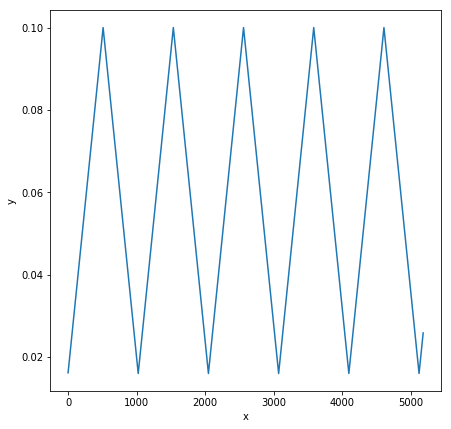

In [13]:
x = range(len(lr_find_lr))
data = pd.DataFrame(data={'y': lr_find_lr, 'x': x})
f, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=data.x, y=data.y, ax=ax)
plt.show()